Contains units, comments, and extra troubleshooting test code

In [18]:
%matplotlib notebook

from modsim import *

In [19]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

In [20]:
degree = UNITS.degree
radian = UNITS.radian

In [21]:
condition = Condition(x = 0 * m, 
                      y = 0 * m,
                      g = 9.8 * m/s**2,
                      mass = 1e-3 * kg,
                      diameter = 1e-2 * m,
                      rho = 1.2 * kg/m**3,
                      C_d = .67,
                      angle = 0 * degree,
                      velocity = 10 * m / s,
                      duration = 2 * s)

### Core Functions

In [22]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition object with x, y, g, mass, diameter, rho, C_d, angle, velocity, duration
    
    returns: System object
    """
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, rel_vy = pol2cart(theta, velocity)
    abs_vy = rel_vy + 53* m / s
    
    # make the initial state
    init = State(x=x, abs_y=y, rel_y=y, vx=vx, abs_vy=abs_vy, rel_vy = rel_vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 200)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x position, absolute y position, relative y position, x velocity, absolute y velocity, relative y velocity)
    t: time
    system: System object with g, mass, area, rho, C_d, ts
    
    returns: sequence (vx, abs_vy, rel_vy, a_x, a_y, a_y)
    """
    x, abs_y, rel_y, vx, abs_vy, rel_vy = state
    unpack(system)
    
    f_drag_x = -rho * vx**2 * C_d * area / 2
    a_x = f_drag_x / mass
    
    f_drag_y = -rho * abs_vy**2 * C_d * area / 2
    a_y = f_drag_y / mass + g
    
    vx = vx + (a_x * t)
    abs_vy = abs_vy + (a_y * t)
    rel_vy = abs_vy - 53 *m/s
    
    return vx, abs_vy, rel_vy, a_x, a_y, a_y

def calc_miss(angle, distance):
    condition.set(angle = angle * degree)
    #print(condition.angle)
    system = make_system(condition)
    #print(system)
    slope_func(system.init, 0*s, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')
    
    T = interp_inverse(xs, kind='cubic')  #adjust later
    hit_time = T(distance)
    print(hit_time)
    hit_height = y_series(hit_time)

    print(hit_height)
    
def plot_trajectory(angle, distance):
    condition.set(angle = angle * degree)
    #print(condition.angle)
    system = make_system(condition)
    #print(system)
    slope_func(system.init, 0*s, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')
     
    #Relative Graph
    newfig()
    plot(xs, rel_ys, label='trajectory')
    
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             title='Relative Trajectory of Dart',
             xlim=[-1, 5],
             ylim=[-1, 5]
            )
    
    #Absolute Graph
    newfig()
    plot(xs, abs_ys, label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             title='Absolute Trajectory of Dart',
             xlim=[0, 0.3],
             ylim=[-0.25, 0])
    
def hit_or_miss(angle, distance, height):
    hit = State(None)
    
    condition.set(angle = angle * degree)
    #print(condition.angle)
    system = make_system(condition)
    #print(system)
    slope_func(system.init, 0*s, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')
    
    T = interp_inverse(xs, kind='cubic')  #adjust later
    hit_time = T(distance)
    #print(hit_time)
    hit_height = y_series(hit_time)
    #print(hit_height)
    
    error = abs(hit_height-height) * m
    
    
    if error <= 0.5 * m:
        hit = True
    else:
        hit = False
        
    return hit

def animate_trajectory(angle, distance):
    """
    condition.set(angle = angle * degree)
    system = make_system(condition)
    slope_func(system.init, 0*s, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')
    """
    #Relative Animation
    newfig()
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=[-1, 5],
             ylim=[-1, 5],
             legend=False)

    for x, y in zip(xs, rel_ys):
        plot(x, y, 'bo', update=True)
        sleep(0.05)
        
def animate2d(xs, ys, speedup=1):
    """Animate the results of a projectile simulation.
    
    xs: x position as a function of time
    ys: y position as a function of time
    
    speedup: how much to divide `dt` by
    """
    # get the time intervals between elements
    ts = xs.index
    dts = np.diff(ts)
    dts = np.append(dts, 0)

    # decorate the plot
    newfig()
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=[xs.min(), xs.max()],
             ylim=[ys.min(), ys.max()],
             legend=False)

    # loop through the values
    for x, y, dt in zip(xs, ys, dts):
        plot(x, y, 'bo', update=True)
        sleep(dt / speedup)

### Setup

In [33]:
system = make_system(condition)
slope_func(system.init, 0*s, system)
run_odeint(system, slope_func)

#For Troubleshooting Run:
#system.results.head()
#system.results.tail()

In [24]:
#Absolute
xs = system.results.x
abs_ys = -system.results.abs_y
vxs = system.results.vx
abs_vys = system.results.abs_vy

#Relative
xs = system.results.x
rel_ys = -system.results.rel_y
vxs = system.results.vx
rel_vys = system.results.rel_vy

In [9]:
#For Troubleshooting
"""
newfig()
plot(xs, label='x')
plot(abs_ys, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')      
"""

"\nnewfig()\nplot(xs, label='x')\nplot(abs_ys, label='y')\n\ndecorate(xlabel='Time (s)',\n         ylabel='Position (m)')      \n"

In [10]:
#For Troubleshooting
"""
newfig()
plot(vxs, label='vx')
plot(abs_vys, label='vy')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')
"""

"\nnewfig()\nplot(vxs, label='vx')\nplot(abs_vys, label='vy')\n\ndecorate(xlabel='Time (s)',\n         ylabel='Velocity (m/s)')\n"

In [11]:
"""
Absolute Trajectory Graph

newfig()
plot(xs, abs_ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         title='Absolute Trajectory of Dart')
         
"""

"\nAbsolute Trajectory Graph\n\nnewfig()\nplot(xs, abs_ys, label='trajectory')\n\ndecorate(xlabel='x position (m)',\n         ylabel='y position (m)',\n         title='Absolute Trajectory of Dart')\n         \n"

In [12]:
#For Troubleshooting
"""
newfig()
plot(vxs, label='vx')
plot(rel_vys, label='vy')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')
"""

"\nnewfig()\nplot(vxs, label='vx')\nplot(rel_vys, label='vy')\n\ndecorate(xlabel='Time (s)',\n         ylabel='Velocity (m/s)')\n"

In [13]:
"""
Relative Trajectory Graph

newfig()
plot(xs, rel_ys, label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         title='Relative Trajectory of Dart')
         
"""

"\nRelative Trajectory Graph\n\nnewfig()\nplot(xs, rel_ys, label='trajectory')\n\ndecorate(xlabel='x position (m)',\n         ylabel='y position (m)',\n         title='Relative Trajectory of Dart')\n         \n"

### Visuals

<IPython.core.display.Javascript object>


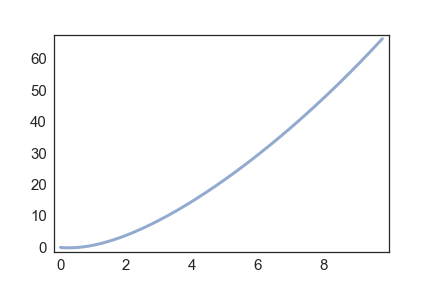

<IPython.core.display.Javascript object>


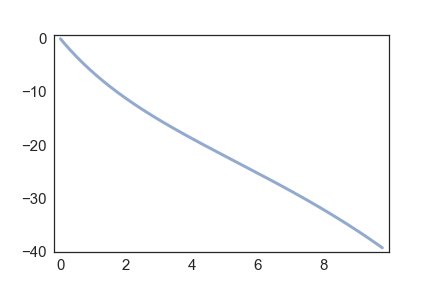

0.30190693128582335
3.864880147285896


<IPython.core.display.Javascript object>


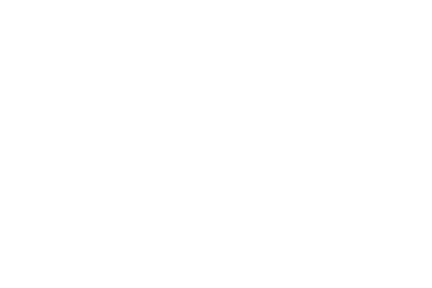

<IPython.core.display.Javascript object>


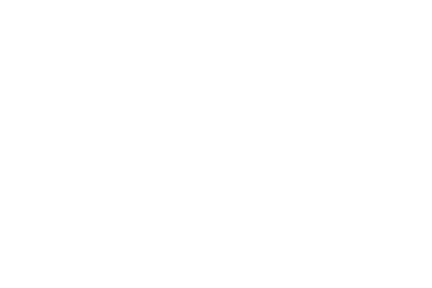

In [25]:
plot_trajectory(45,2)
calc_miss(45,2)

In [16]:
"""
def plot_point(angle, distance, height, hit_or_miss):
    result = hit_or_miss(angle, distance, height)
    #print(result)
    #print(distance)
    #print(height)
    if result == True:
        plot(distance, height)
    
#newfig()
#plot_point(45, 1, 0.55, hit_or_miss)
        
#hit_or_miss(45, 1, 0.55)

distance_set = linspace(.5,2,6)
height_set = linspace(0,4,6)
angle_set = linspace(0,80,6)
colors = ['bo', 'ro', 'go', 'co', 'mo', 'yo']
#plot(distance, height, 'ro-', color = (0.1, 0.5, 0.9))

def sweep_angle(angles, distance, height):
    for angle in angles:
        plot_point(angle, distance, height, hit_or_miss)
        
def sweep_distance(distances, height):
    for distance in distances:
        sweep_angle(angle_set, distance, height)
        #plot_point(70, distance, height, hit_or_miss)

def sweep_height(heights):
    for height in heights:
        sweep_distance(distance_set, height)
        
"""

"\ndef plot_point(angle, distance, height, hit_or_miss):\n    result = hit_or_miss(angle, distance, height)\n    #print(result)\n    #print(distance)\n    #print(height)\n    if result == True:\n        plot(distance, height)\n    \n#newfig()\n#plot_point(45, 1, 0.55, hit_or_miss)\n        \n#hit_or_miss(45, 1, 0.55)\n\ndistance_set = linspace(.5,2,6)\nheight_set = linspace(0,4,6)\nangle_set = linspace(0,80,6)\ncolors = ['bo', 'ro', 'go', 'co', 'mo', 'yo']\n#plot(distance, height, 'ro-', color = (0.1, 0.5, 0.9))\n\ndef sweep_angle(angles, distance, height):\n    for angle in angles:\n        plot_point(angle, distance, height, hit_or_miss)\n        \ndef sweep_distance(distances, height):\n    for distance in distances:\n        sweep_angle(angle_set, distance, height)\n        #plot_point(70, distance, height, hit_or_miss)\n\ndef sweep_height(heights):\n    for height in heights:\n        sweep_distance(distance_set, height)\n        \n"

<IPython.core.display.Javascript object>


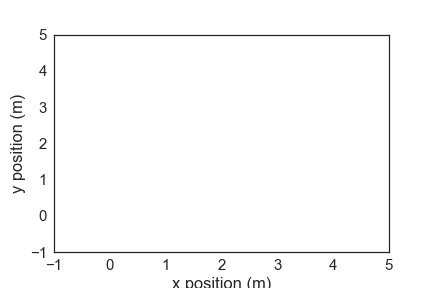

<IPython.core.display.Javascript object>


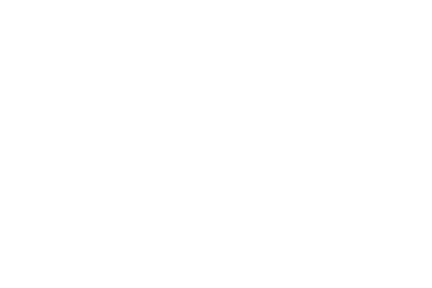

In [30]:
newfig()
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim=[-1, 5],
         ylim=[-1, 5],
         legend=False)

for x, y in zip(xs, rel_ys):
    plot(x, y, 'bo', update=True)
    sleep(0.05)

<IPython.core.display.Javascript object>


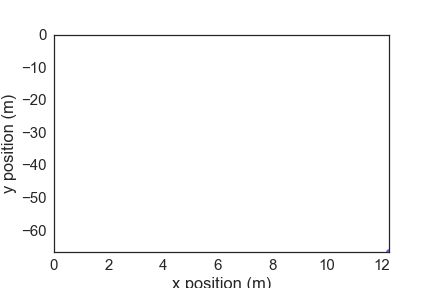

<IPython.core.display.Javascript object>


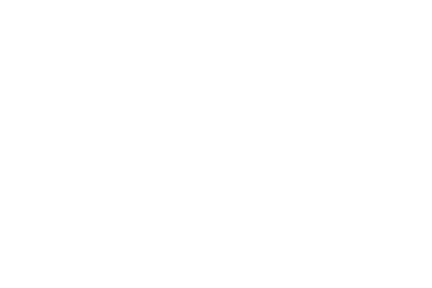

In [32]:
animate2d(system.results.x, system.results.rel_y)